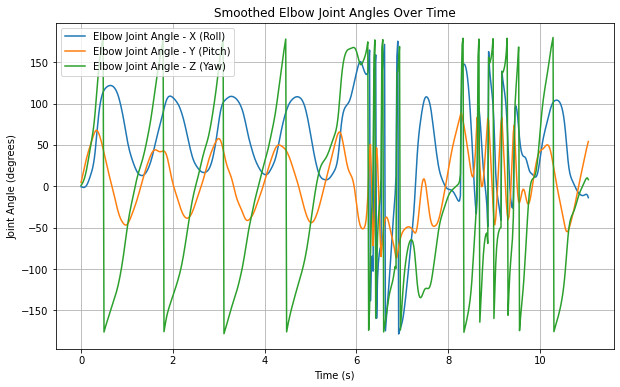

In [2]:
import pandas as pd
import numpy as np
from ahrs.filters import Madgwick
from scipy.spatial.transform import Rotation as R
from scipy.signal import butter, filtfilt
import matplotlib.pyplot as plt

# Step 1: Load IMU data from CSV file
file_path = '../data/merge_1.csv'  # Adjust the path based on your setup
data = pd.read_csv(file_path)

# Step 2: Extract only the relevant columns for RF and RU (Acc and Gyro)
ru_accel = data[['RU_IMU9_Acc_X', 'RU_IMU9_Acc_Y', 'RU_IMU9_Acc_Z']].values
ru_gyro = data[['RU_IMU9_Gyro_X', 'RU_IMU9_Gyro_Y', 'RU_IMU9_Gyro_Z']].values
rf_accel = data[['RF_IMU9_Acc_X', 'RF_IMU9_Acc_Y', 'RF_IMU9_Acc_Z']].values
rf_gyro = data[['RF_IMU9_Gyro_X', 'RF_IMU9_Gyro_Y', 'RF_IMU9_Gyro_Z']].values

# Step 3: Apply a Butterworth low-pass filter to smooth sensor data
def butter_lowpass_filter(data, cutoff, fs, order=4):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return filtfilt(b, a, data, axis=0)

cutoff_frequency = 5  # Adjust based on movement frequency
sample_rate = 52.0  # Sampling rate in Hz

# Apply filtering to smooth both accelerometer and gyroscope data
ru_accel_filtered = butter_lowpass_filter(ru_accel, cutoff_frequency, sample_rate)
ru_gyro_filtered = butter_lowpass_filter(ru_gyro, cutoff_frequency, sample_rate)
rf_accel_filtered = butter_lowpass_filter(rf_accel, cutoff_frequency, sample_rate)
rf_gyro_filtered = butter_lowpass_filter(rf_gyro, cutoff_frequency, sample_rate)

# Step 4: Apply a dead zone to reduce sensitivity to minor noise
def apply_dead_zone(sensor_data, threshold=0.02):
    sensor_data[np.abs(sensor_data) < threshold] = 0
    return sensor_data

# Apply dead zone to the filtered gyroscope data
ru_gyro_filtered = apply_dead_zone(ru_gyro_filtered, threshold=0.02)
rf_gyro_filtered = apply_dead_zone(rf_gyro_filtered, threshold=0.02)

# Step 5: Initialize Madgwick filter with lower beta to reduce gyroscope drift
madgwick = Madgwick(frequency=sample_rate, beta=0.02)  # Lower beta to reduce gyroscope reliance

# Initialize quaternions for RU and RF
q_ru = np.array([1.0, 0.0, 0.0, 0.0])  # Identity quaternion (no rotation)
q_rf = np.array([1.0, 0.0, 0.0, 0.0])  # Same for RF

# Step 6: Initialize lists to store joint angles
joint_angles_x = []
joint_angles_y = []
joint_angles_z = []

# Step 7: Loop through the data to calculate quaternions and joint angles
for i in range(len(ru_accel_filtered)):
    # Update RU quaternion using filtered accelerometer and gyroscope data
    q_ru = madgwick.updateIMU(q_ru, gyr=ru_gyro_filtered[i], acc=ru_accel_filtered[i])
    
    # Update RF quaternion using filtered accelerometer and gyroscope data
    q_rf = madgwick.updateIMU(q_rf, gyr=rf_gyro_filtered[i], acc=rf_accel_filtered[i])
    
    # Calculate relative quaternion between RF and RU (i.e., RF relative to RU)
    r_ru = R.from_quat(q_ru)
    r_rf = R.from_quat(q_rf)
    r_relative = r_ru.inv() * r_rf
    
    # Convert the relative quaternion to Euler angles (roll, pitch, yaw)
    euler_angles = r_relative.as_euler('xyz', degrees=True)
    
    # Store the joint angles (roll, pitch, yaw)
    joint_angles_x.append(euler_angles[0])  # Roll (X-axis)
    joint_angles_y.append(euler_angles[1])  # Pitch (Y-axis)
    joint_angles_z.append(euler_angles[2])  # Yaw (Z-axis)

# Step 8: Generate time data for plotting (based on sample rate)
time = np.arange(0, len(joint_angles_x) / sample_rate, 1 / sample_rate)

# Step 9: Plot the joint angles over time
plt.figure(figsize=(10, 6))
plt.plot(time, joint_angles_x, label='Elbow Joint Angle - X (Roll)')
plt.plot(time, joint_angles_y, label='Elbow Joint Angle - Y (Pitch)')
plt.plot(time, joint_angles_z, label='Elbow Joint Angle - Z (Yaw)')
plt.xlabel('Time (s)')
plt.ylabel('Joint Angle (degrees)')
plt.title('Smoothed Elbow Joint Angles Over Time')
plt.legend()
plt.grid(True)
plt.show()
